In [62]:
import music21 as m21
import os
from collections import Counter
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [63]:
# Set custom MuseScore path (Comment it out if necessary)
m21.environment.UserSettings()['musescoreDirectPNGPath'] = "/Applications/MuseScore 3.app/Contents/MacOS/mscore"

dataset_root = './SymbTr-2.4.3'
scores_root = os.path.join(dataset_root, 'MusicXML')
score_filenames = os.listdir(scores_root)

## Selecting scores from the dataset

In this part we are preparing two subsets of makam scores from all the available scores in the dataset.
We decided to work on dugah and rast makams. 
Dugah is characterised by tonic in A. 
Rast has a tonic in G.


 most used makams
 [('hicaz', 157), ('nihavent', 130), ('ussak', 118), ('rast', 109), ('huzzam', 96), ('segah', 92), ('huseyni', 92), ('mahur', 88), ('hicazkar', 79), ('kurdilihicazkar', 70)]

=====
 
 most used makams:



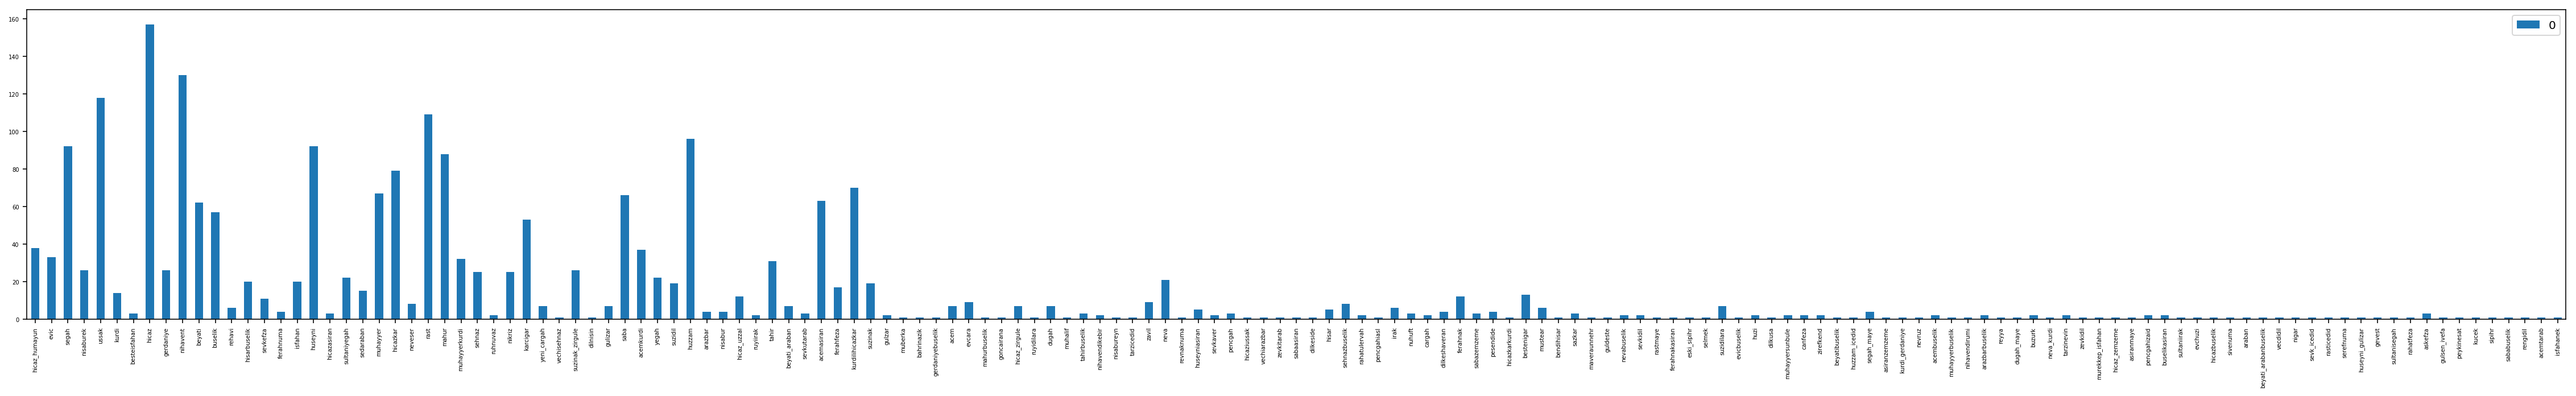


=====
 
 most used makams_and_forms:



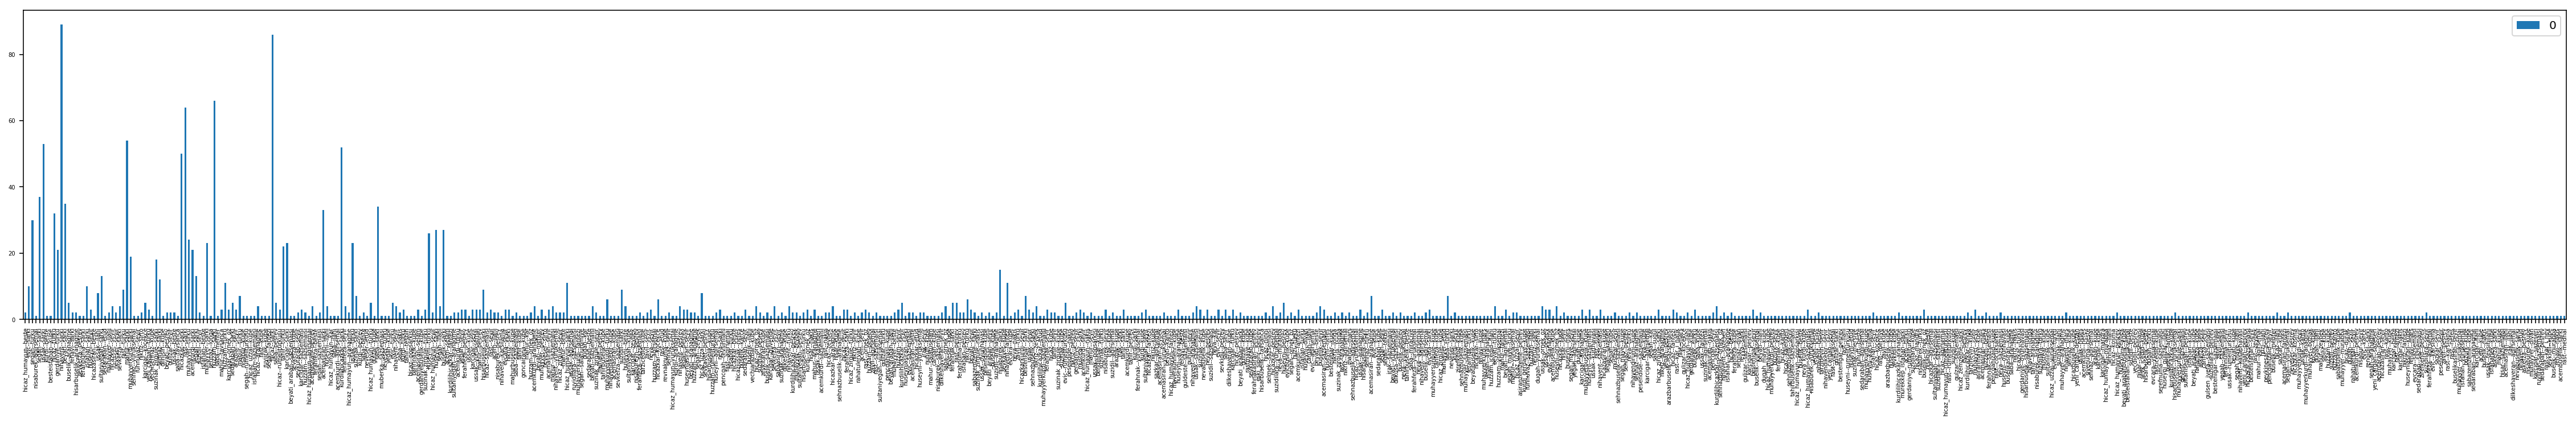

In [64]:
#rank makams by most used
allScores = os.listdir(scores_root)

def get_makam(string):
    return string.split('--')[0]

def get_makam_and_form(string):
    return string.split("--")[0] + "--" + string.split("--")[1]

makamsDic = {}
for f in allScores:
    makam = get_makam(f)
    if(makam in makamsDic):
        makamsDic[makam] = makamsDic[makam]+1
    else:
        makamsDic[makam] = 1

rankedMakams = [(k, makamsDic[k]) for k in sorted(makamsDic, key=makamsDic.get, reverse=True)]
print("\n most used makams\n",rankedMakams[:10])


#makams_and_forms ocurrence histogram
makams=[]
for m in allScores:
    makams.append(get_makam(m))
makams_counts = Counter(makams)
df = pd.DataFrame.from_dict(makams_counts, orient='index')
df.plot(kind='bar', fontsize=5, figsize=(40, 5))
plt.savefig("makams_ocurrence.png")
print("\n=====\n","\n most used makams:\n")
plt.show()
 

#makams_and_forms ocurrence histogram
makams_and_forms=[]
for m in allScores:
    makams_and_forms.append(get_makam_and_form(m))
makams_and_forms_counts = Counter(makams_and_forms)
df = pd.DataFrame.from_dict(makams_and_forms_counts, orient='index')
df.plot(kind='bar', fontsize=5, figsize=(40, 5))
plt.savefig("makams_and_forms_ocurrence.png")
print("\n=====\n","\n most used makams_and_forms:\n")
plt.show()

In [6]:
# filter the scores
makams_by_tonic = {
    "dugah": ['hicaz', 'dugah', 'huseyni', 'acemkurdi', 'isfahan', 'hicaz_humayun', 'sehnaz', 
                'karcigar', 'ussak', 'gerdaniye', 'muhayyerkurdi', 'saba', 'nisaburek', 'buselik',
                'muhayyer', 'beyati', 'tahir', 'neva'],
    "rast": ['mahur', 'rast', 'nikriz', 'hicazkar', 'nihavent', 'kurdilihicazkar']
}

scores_by_tonic = {
    "dugah": [],
    "rast": []
}

tonic_note = {
    "dugah": m21.note.Note("A"),
    "rast": m21.note.Note("G")
}

for score in score_filenames:
    score_makam = score.split('--')[0]
    for tonic in makams_by_tonic.keys():
        if score_makam in makams_by_tonic[tonic]:
            scores_by_tonic[tonic].append(score)

all_scores = scores_by_tonic["dugah"] + scores_by_tonic["rast"]

for tonic, scores in scores_by_tonic.items():
    print("%d scores in %s makam" % (len(scores), tonic))

935 scores in dugah makam
501 scores in rast makam


## Preprocessing scores
All the MusicXML scores have to be preprocessed before we start working on them. There is a couple of XML tags that are not supported by music21. For this reason, we are removing them before moving on.

In [7]:
# Create a directory for parsed scores
parsed_scores_root = "./parsed_scores"
try:  
    os.mkdir(parsed_scores_root)
except OSError:  
    pass

In [8]:
def parse_score(score_filename):
    '''
    Removes MusicXML information that may be useless or misleading in Makam context.
    Moreover some of the MXL tags are not supported by music21.
    '''
    tree = ET.parse(os.path.join(scores_root, score_filename))
    root = tree.getroot()
    
    for k in root.iter('key'):
        for ks in k.findall('key-step'):
            k.remove(ks)
        for ka in k.findall('key-accidental'):
            k.remove(ka)
        for ka in k.findall('key-alter'):
            k.remove(ka)
            
    # Save the new xml files to be later loaded with music21
    new_score = os.path.join(parsed_scores_root, score_filename)
    tree.write(new_score)

In [9]:
for score_name in all_scores:
    parse_score(score_name)

## Non-standard Makam accidentals handling
Makam music is using a different octave division than European music. One octave is normally divided into 53 equal parts, sometimes called Commas. Turkish makam is using Holdrian-Mercator commas (Hc). To handle the intervals calculation properly, we have to implement our own methods dealing with provided intervals correctly. These two functions do the job.

In [12]:
# Number of comas added by an accidental
accidental_mapping = {
    'double-slash-flat': -8,
    'flat': -5,
    'slash-flat': -4,
    'quater-flat': -1,
    'half-flat': -1,
    
    'quarter-sharp': 1,
    'half-sharp': 1,
    'sharp': 4,
    'slash-quarter-sharp': 5,
    'slash-sharp': 8,
}

def comma_interval(noteA, noteB):
    '''
    In Makam music each whole tone is divided into 9 "Commas".
    This function returns number of Commas in between two notes, taking into
    account non-standard accidental interpretation.
    
    Parameters:
        * duration [Boolean] - should note duration be included in the interval?
    Returns:
        * if duration=True - list of tuples of (interval, duration)
        * if duration=False - list of intervals
    '''
    for note in [noteA, noteB]:
        if note.pitch.accidental:
            acc_name = note.pitch.accidental.name
            note.pitch.microtone = accidental_mapping[acc_name]*200/9
            note.pitch.accidental = None
    
    interval = np.round(9*m21.interval.notesToChromatic(noteA, noteB).semitones*100/200, decimals=2)
    if duration:
        return (interval, noteB.duration.quarterLength)
    else:
        return interval
    

def cents_interval(noteA, noteB, duration=False):
    '''
    In Makam music each whole tone is divided into 9 "Commas".
    This function returns number of cents in between two notes, taking into
    account non-standard accidental interpretation.
    
    Parameters:
        * duration [Boolean] - should note duration be included in the interval?
    Returns:
        * if duration=True - list of tuples of (interval, duration)
        * if duration=False - list of intervals
    '''
    for note in [noteA, noteB]:
        if note.pitch.accidental:
            acc_name = note.pitch.accidental.name
            note.pitch.microtone = accidental_mapping[acc_name]*200/9
            note.pitch.accidental = None
    
    interval = np.round(m21.interval.notesToChromatic(noteA, noteB).semitones*100, decimals=3)
    if duration:
        return (interval, noteB.duration.quarterLength)
    else:
        return interval
        
    

In [40]:
# Testing intervals
# noteA = m21.note.Note("C2")
# noteB = m21.note.Note("C2")
# acc = m21.pitch.Accidental()
# acc.name = "slash-sharp"
# noteB.pitch.accidental = acc
# comma_interval(noteA, noteB)
#re = m21.note.Note("D")
#re.pitch.accidental="sharp"
#fa = m21.note.Note("F")
#interval = m21.interval.notesToChromatic(re, fa)
#cents_interval(re, fa)

211.111

## Helper methods
We need a couple of methods before generating n-grams. They are for extracting notes from score, calculating intervals, etc.

In [13]:
def get_notes(score_filename):
    '''
    Returns list of notes from a score,
    '''
    score_path = os.path.join(parsed_scores_root, score_filename)
    score = m21.converter.parse(score_path)
    notes = score.parts[0].flat.notes
    return notes

def transform_to_intervals(notes, duration=False):
    '''
    Returns a list of a relative cent distances in between consecutive notes.
    '''
    intervals = [0]
    for i in range(len(notes)-1):
        noteA = notes[i]
        noteB = notes[i+1]
        intervals.append(cents_interval(noteA, noteB, duration=duration))
    return intervals

def transform_to_tonic_intervals(tonic, notes, duration=False):
    '''
    Returns a list of cent distances from a given tonic note.
    '''
    intervals = []
    for note in notes:
        intervals.append(cents_interval(tonic, note, duration=duration))
    return intervals

def get_note_name(note):
    '''
    Helper method returning note string including non-standard makam accidentals.
    '''
    accidental = note.pitch.accidental.name if note.pitch.accidental else ''
    return "%s%d %s" % (note.name, note.octave, accidental)

## Pattern search
At this step we are calculating defined length n-grams and calculating the occurances dictionary. Next, we sort the dictionary to get a list of tupples defined as [(1st_most_popular_ngram, number_of_occurances), ..., and so on ]

In [14]:
def generate_ngrams(values, n=4):
    '''
    Returns a list of ngrams of length n
    '''
    ngrams = []
    for i in range(len(values)-n):
        ngrams.append(values[i:i+n])
    return ngrams
    

In [16]:
# Generate ngrams
occurances = {}
ngram_length = 5

for tonic_name, scores in scores_by_tonic.items():
    occurances[tonic_name] = {}
    for score in scores:
        notes = get_notes(score)
        tonic_intervals = transform_to_tonic_intervals(tonic_note[tonic_name], notes)
        ngrams = generate_ngrams(tonic_intervals, n=ngram_length)
        for ngram in ngrams:
            if not str(ngram) in occurances[tonic_name]:
                occurances[tonic_name][str(ngram)] = 0
            occurances[tonic_name][str(ngram)] += 1


In [17]:
occurances.keys()

dict_keys(['dugah', 'rast'])

In [18]:
ranked_ngrams = {}
for tonic_name, occ in occurances.items():
    ranked_ngrams[tonic_name] =  [(k, occ[k]) for k in sorted(occ, key=occ.get, reverse=True)]
    
#ranked_ngrams = [(k, occurances[k]) for k in sorted(occurances, key=occurances.get, reverse=True)]

In [19]:
occurances['dugah'][:10]

TypeError: unhashable type: 'slice'

In [108]:
ranked_ngrams['rast'][:10]

[('[0, 0, 0, 0, 0, 0, 0, 0]', 176),
 ('[1200, 1000, 788.889, 700, 500, 288.889, 500, 700]', 99),
 ('[1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]', 84),
 ('[200, 377.778, 500, 900, 700, 500, 377.778, 200]', 74),
 ('[1200, 1000, 788.889, 700, 500, 288.889, 88.889, 0]', 74),
 ('[500, 700, 788.889, 700, 500, 288.889, 200, 0]', 65),
 ('[788.889, 700, 500, 288.889, 200, 0, -111.111, 0]', 59),
 ('[200, 288.889, 500, 700, 788.889, 700, 500, 288.889]', 58),
 ('[1200, 1088.889, 811.111, 700, 500, 377.778, 500, 700]', 58),
 ('[288.889, 500, 700, 788.889, 700, 500, 288.889, 200]', 57),
 ('[700, 811.111, 1088.889, 1200, 1088.889, 811.111, 700, 500]', 55),
 ('[1200, 1088.889, 811.111, 700, 500, 377.778, 111.111, 0]', 55),
 ('[1200, 1000, 1000, 788.889, 788.889, 700, 700, 500]', 55),
 ('[900, 700, 500, 377.778, 200, 0, 200, 377.778]', 53),
 ('[700, 788.889, 1000, 1200, 1000, 788.889, 700, 500]', 53),
 ('[500, 288.889, 500, 700, 788.889, 700, 500, 288.889]', 52),
 ('[500, 400, 200, 0, -88.889, -30

## Pattern search including note duration

In [56]:
occurances_dur = {}
score_occurances = {}
# For each tonic
for tonic_name, scores in scores_by_tonic.items():
    occurances_dur[tonic_name] = {}
    score_occurances[tonic_name] = {}
    # For each score
    for score in scores:
        # Get all the notes from the score
        notes = get_notes(score)
        # Transform notes to intervals from tonic note
        tonic_intervals = transform_to_tonic_intervals(tonic_note[tonic_name], notes, duration=True)
        
        # Generate all possible ngrams
        ngrams = generate_ngrams(tonic_intervals, n=ngram_length)
        for ngram in ngrams:
            # Counting how many times did the ngram occur in general
            if not str(ngram) in occurances_dur[tonic_name]:
                occurances_dur[tonic_name][str(ngram)] = 0
            occurances_dur[tonic_name][str(ngram)] += 1
            
            # For each ngram aggregating the scores that it appeared in
            if str(ngram) not in score_occurances[tonic_name]:
                score_occurances[tonic_name][str(ngram)] = set()
            score_occurances[tonic_name][str(ngram)].add(score)

In [59]:
len(score_occurances['rast']['[(788.889, 0.5), (700, 0.5), (500, 0.5), (288.889, 0.5), (200, 0.5)]'])


37

In [41]:
ranked_ngrams_dur = {}
for tonic_name, occ in occurances_dur.items():
    ranked_ngrams_dur[tonic_name] =  [(k, occ[k]) for k in sorted(occ, key=occ.get, reverse=True)]

In [61]:
print("Rast")
print("\n".join([str(rn) for rn in ranked_ngrams_dur['rast'][:10]]))
print("Dugah")
print("\n".join([str(rn) for rn in ranked_ngrams_dur['dugah'][:10]]))

Rast
('[(788.889, 0.5), (700, 0.5), (500, 0.5), (288.889, 0.5), (200, 0.5)]', 144)
('[(700, 0.25), (788.889, 0.25), (700, 0.25), (500, 0.25), (288.889, 0.25)]', 136)
('[(1200, 0.5), (1000, 0.5), (788.889, 0.5), (700, 0.5), (500, 0.5)]', 112)
('[(1200, 0.25), (1088.889, 0.25), (811.111, 0.25), (700, 0.25), (500, 0.25)]', 108)
('[(700, 0.5), (500, 0.5), (288.889, 0.5), (200, 0.5), (0, 0.5)]', 107)
('[(788.889, 0.25), (700, 0.25), (500, 0.25), (288.889, 0.25), (200, 0.25)]', 106)
('[(200, 0.25), (200, 0.25), (0, 0.25), (0, 0.25), (-111.111, 0.25)]', 99)
('[(900, 0.5), (700, 0.5), (500, 0.5), (377.778, 0.5), (200, 0.5)]', 96)
('[(788.889, 0.5), (700, 0.5), (500, 0.5), (288.889, 0.5), (500, 0.5)]', 92)
('[(1200, 0.25), (1000, 0.25), (788.889, 0.25), (700, 0.25), (500, 0.25)]', 92)
Dugah
('[(1200, 0.5), (1000, 0.5), (800, 0.5), (700, 0.5), (500, 0.5)]', 479)
('[(800, 0.5), (700, 0.5), (500, 0.5), (300, 0.5), (177.778, 0.5)]', 263)
('[(1000, 0.5), (800, 0.5), (700, 0.5), (500, 0.5), (300, 0.5

## Playing with results

In [17]:
def ngram_to_intervals(ngram):
    return [float(item) for item in ngram[1:-1].split(',')]

def ngram_to_notes(ngram, base_note="C2"):
    '''
    Transforms ngram to music21 stream
    '''
    intervals = ngram_to_intervals(ngram)
    stream = m21.stream.Stream()
    
    note = m21.note.Note(base_note)
    stream.append(note)
    accumulated_interval = 0
    for interval in intervals:
        note = m21.note.Note(base_note)
        accumulated_interval += interval*200/9
        note.pitch.microtone = accumulated_interval
        stream.append(note)
    return stream

def play_ngram(ngram, base_note="C2"):
    '''
    Plays given ngram with use of pygame
    '''
    stream = ngram_to_notes(ngram, base_note=base_note)
    player = m21.midi.realtime.StreamPlayer(stream).play()

In [ ]:
# Having fun
import random
# Take 0,1% first most frequent ngrams
ngrams = ranked_ngrams.copy()[:int(len(ranked_ngrams)/1000)]
# Generate random permutation
ngrams = np.random.permutation(ngrams)
# Concatenate first 6 ngrams
intervals = []
for ngram, _ in ngrams:
    intervals += ngram_to_intervals(ngram)
# Play resulting phrase
play_ngram(str(intervals), 'C4')

In [18]:
play_ngram('[8.0, 5.5, 18.0, -9.0, -9.0, -5.5, -8.0, -9.0]', base_note='D2')

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


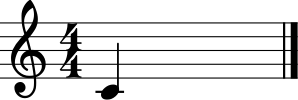

In [37]:
stream = m21.stream.Stream()
note = m21.note.Note("C")
stream.append(note)
stream.show()